# Activation patching

- What to patch:
  - Patch single activations
    - Attention: layer, token, head
    - MLP: layer, token
  - Patch multiple activations from a corrupted input to the clean input

- How to patch:
  - Replace the activation
  - Steer the activation

- Patch from where:
  - Same model, different prompts (clean vs corrupted).
  - Different models, same prompt.
  - Different models, different prompts (clean vs corrupted).

- What to look for after patching:
  - Compare the log-probs between patch & not patch
  - The idea is to see what layers and what tokens are important.

- Downside of manual activation patching experiments:
  - Need a correct correspondence of the token size between clean and corrupted
    prompts
  - Slow
  - How to get and substitute output greatly depends on the type of layer
  - Need to know the target tokens we want to check
    - The idea is to find the target tokens that have the highest affect


In [1]:
import torch
from dawnet.inspector import LLMInspector
from dawnet.tokens import Tokens
from dawnet import op
import seaborn as sns

torch.set_grad_enabled(False)

torch.autograd.grad_mode.set_grad_enabled(mode=False)

In [2]:
model_id = "allenai/Olmo-3-7B-Instruct-SFT"
device = torch.device("mps")
insp = LLMInspector.from_hf(model_id).to(device=device)

`rope_scaling`'s beta_fast field must be a float, got 32
`rope_scaling`'s beta_slow field must be a float, got 1


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


In [3]:
CLEAN_PROMPT = "When John and Mary went to the store, John gave the bag to"
CORRUPTED_PROMPT = "When John and Mary went to the store, she gave the bag to"
TARGET_TOKEN = 9
CLS_TRUE = 3757
CLS_FALSE = 10244

# CLEAN_PROMPT = "Robert woke up at 8:00am while Samuel woke up at 6:00am, so the person woke up later is"
# CORRUPTED_PROMPT = "Robert woke up at 8:00am while Samuel woke up at 9:00am, so the person woke up later is"
# TARGET_TOKEN = 16
# CLS_TRUE = 8397
# CLS_FALSE = 31907

In [4]:
with insp.ctx(detach_state=False) as clean_state:
    clean_output = insp.infer(CLEAN_PROMPT, chat=False, use_original=True)
print(clean_output)

LogitTensors (shape torch.Size([14, 100278])): (tensor(10455, device='mps:0'), ' Mary')


In [5]:
with insp.ctx(detach_state=False) as corrupted_state:
    corrupted_output = insp.infer(CORRUPTED_PROMPT, chat=False, use_original=True)
print(corrupted_output)

LogitTensors (shape torch.Size([14, 100278])): (tensor(1461, device='mps:0'), ' him')


In [6]:
print(clean_output.logits[-1,31907], clean_output.logits[-1,8397])
print(corrupted_output.logits[-1,31907], corrupted_output.logits[-1,8397])

tensor(4.3524, device='mps:0') tensor(6.9028, device='mps:0')
tensor(4.3037, device='mps:0') tensor(6.8017, device='mps:0')


In [7]:
tokens = Tokens([insp.tokenizer.encode(CORRUPTED_PROMPT)], insp.tokenizer)
tokens.view()

## Patch a single activation

Select the appropriate `name_regex` to handle the activation patching.

### Single model, 2 different prompts

In [8]:
insp.remove_all()
name_regex = r"model.layers.\d+$"    # used for getting
name_pattern = "model.layers.{layer_idx}"      # used for substituting
insp.add(op.GetOutput(), name_regex=name_regex)

Added to layer ['model.layers.0', 'model.layers.1', 'model.layers.2', 'model.layers.3', 'model.layers.4', 'model.layers.5', 'model.layers.6', 'model.layers.7', 'model.layers.8', 'model.layers.9', 'model.layers.10', 'model.layers.11', 'model.layers.12', 'model.layers.13', 'model.layers.14', 'model.layers.15', 'model.layers.16', 'model.layers.17', 'model.layers.18', 'model.layers.19', 'model.layers.20', 'model.layers.21', 'model.layers.22', 'model.layers.23', 'model.layers.24', 'model.layers.25', 'model.layers.26', 'model.layers.27', 'model.layers.28', 'model.layers.29', 'model.layers.30', 'model.layers.31', 'model.layers.32', 'model.layers.33', 'model.layers.34', 'model.layers.35']


In [9]:
# get the tokens from some place
with insp.ctx(detach_state=True) as clean_state:
    clean_output = insp.infer(CLEAN_PROMPT, chat=False)
print(clean_output)

LogitTensors (shape torch.Size([14, 151936])): (tensor(10244, device='mps:0'), ' Mary')


In [11]:
clean_state['output']['model.layers.0']

tensor([[[ 1.0416e+01, -3.0249e+00,  2.3518e+00,  ...,  3.2380e-01,
          -1.7276e-01,  6.2741e-02],
         [ 3.9990e+00, -1.4887e+00,  1.0076e+00,  ...,  2.5246e-01,
          -5.8601e-02, -1.3308e-01],
         [ 4.1106e+00, -7.9101e-01,  9.2293e-01,  ...,  1.1524e-01,
          -6.3957e-02, -2.4922e-02],
         ...,
         [ 5.6527e+00, -1.0616e+00,  1.4061e+00,  ..., -2.4720e-03,
          -1.3973e-03,  9.8506e-03],
         [ 2.3397e+00, -1.2324e+00,  8.9781e-01,  ..., -2.4272e-02,
           5.9846e-02,  6.6062e-02],
         [ 2.2038e+00, -6.1032e-01,  6.4810e-01,  ...,  2.0979e-02,
           6.9858e-02,  1.2590e-02]]], device='mps:0')

In [12]:
result = {}

for layer_idx in range(len(insp.model.model.layers)):
    layer_name = name_pattern.format(layer_idx=layer_idx)
    insp.remove_all()
    set_op = op.SetOutput()
    insp.add(set_op, name=layer_name)
    for target_token in range(len(insp.tokenizer.encode(CORRUPTED_PROMPT))):
        def output_fn(obj):
            obj[0,target_token] = clean_state['output'][layer_name][0,target_token]
            return obj
        with insp.ctx([set_op.run_params(output_fn=output_fn)]):
            corrupted_output = insp.infer(CORRUPTED_PROMPT, chat=False)
            if layer_name not in result:
                result[layer_name] = []
            result[layer_name].append((
                corrupted_output.logits[-1][CLS_TRUE].item(),
                corrupted_output.logits[-1][CLS_FALSE].item()
            ))

Added to layer ['model.layers.0']
Added to layer ['model.layers.1']
Added to layer ['model.layers.2']
Added to layer ['model.layers.3']
Added to layer ['model.layers.4']
Added to layer ['model.layers.5']
Added to layer ['model.layers.6']
Added to layer ['model.layers.7']
Added to layer ['model.layers.8']
Added to layer ['model.layers.9']
Added to layer ['model.layers.10']
Added to layer ['model.layers.11']
Added to layer ['model.layers.12']
Added to layer ['model.layers.13']
Added to layer ['model.layers.14']
Added to layer ['model.layers.15']
Added to layer ['model.layers.16']
Added to layer ['model.layers.17']
Added to layer ['model.layers.18']
Added to layer ['model.layers.19']
Added to layer ['model.layers.20']
Added to layer ['model.layers.21']
Added to layer ['model.layers.22']
Added to layer ['model.layers.23']
Added to layer ['model.layers.24']
Added to layer ['model.layers.25']
Added to layer ['model.layers.26']
Added to layer ['model.layers.27']
Added to layer ['model.layers.

In [14]:
insp.tokenizer.decode(CLS_TRUE)

' John'

In [15]:
print(clean_output.logits[-1][CLS_TRUE].item(), clean_output.logits[-1][CLS_FALSE].item())
diffs = []
for key, value in result.items():
    r = ["John" if o0 > o1 else "Mary" for (o0, o1) in value]
    rverse = [o1 - o0 for (o0, o1) in value]
    diffs.append(rverse)
    print(key, r)

7.379772663116455 15.60390567779541
model.layers.0 ['John', 'John', 'John', 'John', 'John', 'John', 'John', 'John', 'John', 'Mary', 'John', 'John', 'John', 'John']
model.layers.1 ['John', 'John', 'John', 'John', 'John', 'John', 'John', 'John', 'John', 'Mary', 'John', 'John', 'John', 'John']
model.layers.2 ['John', 'John', 'John', 'John', 'John', 'John', 'John', 'John', 'John', 'Mary', 'John', 'John', 'John', 'John']
model.layers.3 ['John', 'John', 'John', 'John', 'John', 'John', 'John', 'John', 'John', 'Mary', 'John', 'John', 'John', 'John']
model.layers.4 ['John', 'John', 'John', 'John', 'John', 'John', 'John', 'John', 'John', 'Mary', 'John', 'John', 'John', 'John']
model.layers.5 ['John', 'John', 'John', 'John', 'John', 'John', 'John', 'John', 'John', 'Mary', 'John', 'John', 'John', 'John']
model.layers.6 ['John', 'John', 'John', 'John', 'John', 'John', 'John', 'John', 'John', 'Mary', 'John', 'John', 'John', 'John']
model.layers.7 ['John', 'John', 'John', 'John', 'John', 'John', 'Joh

Lighter means logit of corrupted output > logit of original output


<Axes: >

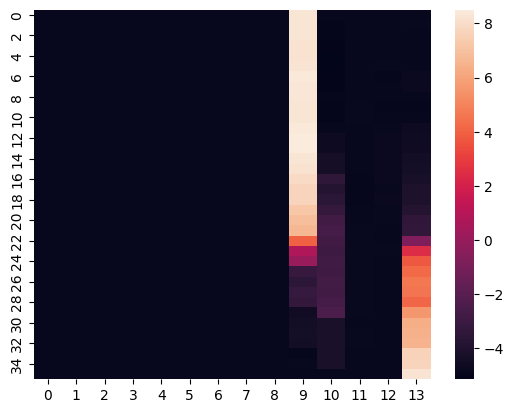

In [18]:
print("Lighter means logit of corrupted output > logit of original output")
sns.heatmap(diffs)

### 2 models of similar architecture, 2 different prompts

In [19]:
model_id2 = "Qwen/Qwen3-4B-Instruct-2507"
insp2 = LLMInspector.from_hf(model_id2).to(device=device)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [20]:
insp2.remove_all()
name_regex = r"model.layers.\d+$"    # used for getting
name_pattern = "model.layers.{layer_idx}"      # used for substituting
insp2.add(op.GetOutput(), name_regex=name_regex)

Added to layer ['model.layers.0', 'model.layers.1', 'model.layers.2', 'model.layers.3', 'model.layers.4', 'model.layers.5', 'model.layers.6', 'model.layers.7', 'model.layers.8', 'model.layers.9', 'model.layers.10', 'model.layers.11', 'model.layers.12', 'model.layers.13', 'model.layers.14', 'model.layers.15', 'model.layers.16', 'model.layers.17', 'model.layers.18', 'model.layers.19', 'model.layers.20', 'model.layers.21', 'model.layers.22', 'model.layers.23', 'model.layers.24', 'model.layers.25', 'model.layers.26', 'model.layers.27', 'model.layers.28', 'model.layers.29', 'model.layers.30', 'model.layers.31', 'model.layers.32', 'model.layers.33', 'model.layers.34', 'model.layers.35']


#### Understand the activation difference

In [21]:
# get the tokens from some place
with insp2.ctx(detach_state=True) as clean_state2:
    clean_output2 = insp2.infer(CLEAN_PROMPT, chat=False)
print(clean_output2)

LogitTensors (shape torch.Size([14, 151936])): (tensor(10244, device='mps:0'), ' Mary')


In [22]:
# get the corrupted tokens
with insp2.ctx(detach_state=True) as corrupted_state2:
    corrupted_output2 = insp2.infer(CORRUPTED_PROMPT, chat=False)
print(corrupted_output2)

LogitTensors (shape torch.Size([14, 151936])): (tensor(3757, device='mps:0'), ' John')


In [33]:
with insp.ctx(detach_state=True) as clean_state:
    clean_output = insp.infer(CLEAN_PROMPT, chat=False)
print(clean_output)

LogitTensors (shape torch.Size([14, 151936])): (tensor(10244, device='mps:0'), ' Mary')


In [34]:
with insp.ctx(detach_state=True) as corrupted_state:
    corrupted_output = insp.infer(CORRUPTED_PROMPT, chat=False)
print(corrupted_output)

LogitTensors (shape torch.Size([14, 151936])): (tensor(3757, device='mps:0'), ' John')


In [35]:
for layer_idx in range(36):
    diff2 = clean_state2["output"][f"model.layers.{layer_idx}"] - corrupted_state2["output"][f"model.layers.{layer_idx}"]
    diff1 = clean_state["output"][f"model.layers.{layer_idx}"] - corrupted_state["output"][f"model.layers.{layer_idx}"]
    print(layer_idx, torch.cosine_similarity(diff1[0, TARGET_TOKEN], diff2[0, TARGET_TOKEN], dim=0))

0 tensor(0.9926, device='mps:0')
1 tensor(0.9892, device='mps:0')
2 tensor(0.9837, device='mps:0')
3 tensor(0.9831, device='mps:0')
4 tensor(0.9805, device='mps:0')
5 tensor(0.9771, device='mps:0')
6 tensor(0.9704, device='mps:0')
7 tensor(0.9664, device='mps:0')
8 tensor(0.9597, device='mps:0')
9 tensor(0.9600, device='mps:0')
10 tensor(0.9644, device='mps:0')
11 tensor(0.9652, device='mps:0')
12 tensor(0.9624, device='mps:0')
13 tensor(0.9605, device='mps:0')
14 tensor(0.9583, device='mps:0')
15 tensor(0.9542, device='mps:0')
16 tensor(0.9559, device='mps:0')
17 tensor(0.9520, device='mps:0')
18 tensor(0.9496, device='mps:0')
19 tensor(0.9473, device='mps:0')
20 tensor(0.9478, device='mps:0')
21 tensor(0.9442, device='mps:0')
22 tensor(0.9563, device='mps:0')
23 tensor(0.9573, device='mps:0')
24 tensor(0.9553, device='mps:0')
25 tensor(0.9520, device='mps:0')
26 tensor(0.9512, device='mps:0')
27 tensor(0.9480, device='mps:0')
28 tensor(0.9481, device='mps:0')
29 tensor(0.9426, device

In [36]:
print(f"{diff2[0, TARGET_TOKEN]=}")
print(f"{diff1[0, TARGET_TOKEN]=}")
print(f"{torch.cosine_similarity(diff1[0, TARGET_TOKEN], diff2[0, TARGET_TOKEN], dim=0)=}")

diff2[0, TARGET_TOKEN]=tensor([43.0633, -7.5838, -4.6187,  ...,  2.2007, -0.4313, -7.9104],
       device='mps:0')
diff1[0, TARGET_TOKEN]=tensor([ -8.9603, -10.4141,   1.6121,  ...,   2.2813,   1.7947,  -6.8534],
       device='mps:0')
torch.cosine_similarity(diff1[0, TARGET_TOKEN], diff2[0, TARGET_TOKEN], dim=0)=tensor(0.8135, device='mps:0')


In [37]:
for token_idx in range(len(insp.tokenizer.encode(CORRUPTED_PROMPT))):
    print(token_idx, torch.cosine_similarity(diff1[0, token_idx], diff2[0, token_idx], dim=0))

0 tensor(0., device='mps:0')
1 tensor(0., device='mps:0')
2 tensor(0., device='mps:0')
3 tensor(0., device='mps:0')
4 tensor(0., device='mps:0')
5 tensor(0., device='mps:0')
6 tensor(0., device='mps:0')
7 tensor(0., device='mps:0')
8 tensor(0., device='mps:0')
9 tensor(0.8135, device='mps:0')
10 tensor(0.7842, device='mps:0')
11 tensor(0.5614, device='mps:0')
12 tensor(0.7270, device='mps:0')
13 tensor(0.8943, device='mps:0')


In [41]:
result = {}

for layer_idx in range(len(insp.model.model.layers)):
    layer_name = name_pattern.format(layer_idx=layer_idx)
    insp.remove_all()
    set_op = op.SetOutput()
    insp.add(set_op, name=layer_name)
    diff2 = clean_state2["output"][f"model.layers.{layer_idx}"] - corrupted_state2["output"][f"model.layers.{layer_idx}"]
    for target_token in range(len(insp.tokenizer.encode(CORRUPTED_PROMPT))):
        def output_fn(obj):
            # obj[0,target_token] = obj[0,target_token] + diff2[0,target_token]
            obj[0,target_token] = clean_state2["output"][f"model.layers.{layer_idx}"][0,target_token]
            return obj
        with insp.ctx([set_op.run_params(output_fn=output_fn)]):
            corrupted_output = insp.infer(CORRUPTED_PROMPT, chat=False)
            if layer_name not in result:
                result[layer_name] = []
            result[layer_name].append((
                corrupted_output.logits[-1][CLS_TRUE].item(),
                corrupted_output.logits[-1][CLS_FALSE].item()
            ))

Added to layer ['model.layers.0']
Added to layer ['model.layers.1']
Added to layer ['model.layers.2']
Added to layer ['model.layers.3']
Added to layer ['model.layers.4']
Added to layer ['model.layers.5']
Added to layer ['model.layers.6']
Added to layer ['model.layers.7']
Added to layer ['model.layers.8']
Added to layer ['model.layers.9']
Added to layer ['model.layers.10']
Added to layer ['model.layers.11']
Added to layer ['model.layers.12']
Added to layer ['model.layers.13']
Added to layer ['model.layers.14']
Added to layer ['model.layers.15']
Added to layer ['model.layers.16']
Added to layer ['model.layers.17']
Added to layer ['model.layers.18']
Added to layer ['model.layers.19']
Added to layer ['model.layers.20']
Added to layer ['model.layers.21']
Added to layer ['model.layers.22']
Added to layer ['model.layers.23']
Added to layer ['model.layers.24']
Added to layer ['model.layers.25']
Added to layer ['model.layers.26']
Added to layer ['model.layers.27']
Added to layer ['model.layers.

In [42]:
for key, value in result.items():
    r = ["John" if o0 > o1 else "Mary" for (o0, o1) in value]
    print(key, r)

model.layers.0 ['John', 'John', 'John', 'John', 'John', 'John', 'John', 'John', 'John', 'Mary', 'John', 'John', 'John', 'John']
model.layers.1 ['John', 'John', 'John', 'John', 'John', 'John', 'John', 'John', 'John', 'Mary', 'John', 'John', 'John', 'John']
model.layers.2 ['John', 'John', 'John', 'John', 'John', 'John', 'John', 'John', 'John', 'Mary', 'John', 'John', 'John', 'John']
model.layers.3 ['John', 'John', 'John', 'John', 'John', 'John', 'John', 'John', 'John', 'Mary', 'John', 'John', 'John', 'John']
model.layers.4 ['John', 'John', 'John', 'John', 'John', 'John', 'John', 'John', 'John', 'Mary', 'John', 'John', 'John', 'John']
model.layers.5 ['John', 'John', 'John', 'John', 'John', 'John', 'John', 'John', 'John', 'Mary', 'John', 'John', 'John', 'John']
model.layers.6 ['John', 'John', 'John', 'John', 'John', 'John', 'John', 'John', 'John', 'Mary', 'John', 'John', 'John', 'John']
model.layers.7 ['John', 'John', 'John', 'John', 'John', 'John', 'John', 'John', 'John', 'Mary', 'John', 

## Patch multiple activations

### Single model, 2 different prompts

It's possible to replace multiple tokens, except the definitive one, and still change the output.

In [221]:
layer_name = name_pattern.format(layer_idx=6)
insp.remove_all()
set_op = op.SetOutput()
insp.add(set_op, name=layer_name)

def output_fn(obj):
    for idx in range(len(insp.tokenizer.encode(CORRUPTED_PROMPT))):
        if idx in (17,):
            continue
        obj[0,idx] = clean_state['output'][layer_name][0,idx]
    return obj

with insp.ctx([set_op.run_params(output_fn=output_fn)]):
    corrupted_output = insp.infer(CORRUPTED_PROMPT, chat=False)
    print((
        corrupted_output.logits[-1][CLS_TRUE].item(),
        corrupted_output.logits[-1][CLS_FALSE].item()
    ))

Added to layer ['model.layers.6']
(15.875990867614746, 10.416614532470703)
